# Simulated Annealing with "light" basis vectors
--------------

Build a basis made of vectors with small Hamming weight.

Run Simulated Annealing with Monte Carlo move consisting of: 
* express the current configuration by means of basis expansion coefficients
* pick a coefficient at random and flip it
* get the new state

In [251]:
include("../code/headers.jl")

## Close look at one iteration

### 1. Starting from the zero codeword

In [260]:
q = 2
n = 500
m = 200
randseed = 1
rng = MersenneTwister(randseed)
lm = LossyModel(q, n, m, randseed=randseed)
lm

Lossy compression model:
 - Factor Graph with n=500 variables and m=200 factors defined on GF(2)
 - Inverse temperatures β₁=Inf for checks and β₂=1.0 for overlap


In [261]:
beta2 = [5e-1, 1e0, 2e0, 5e0]        # overlap temperature for simulated annealing
nbetas = length(beta2)
nsamples = 10000
mc_move = MetropBasisCoeffs()
# Initalize options for SA
betas = hcat(fill(Inf, length(beta2)), beta2)
algo = SA(mc_move=mc_move, nsamples=nsamples, betas = betas)

SA
  mc_move: MetropBasisCoeffs
  betas: Array{Float64}((4, 2)) [Inf 0.5; Inf 1.0; Inf 2.0; Inf 5.0]
  nsamples: Int64 10000
  sample_every: Int64 1
  stop_crit: crit (function of type var"#crit#5707")
  init_state: init (function of type var"#init#5708")


In [262]:
# Initialize basis and basis coefficients
adapt_to_model!(algo.mc_move, lm)
# Initalize arrays to store distortion, etc.
distortions = [fill(0.5, algo.nsamples) for _ in 1:size(algo.betas,1)]
accepted = [falses(algo.nsamples) for _ in 1:size(algo.betas,1)]
dE = [zeros(algo.nsamples) for _ in 1:size(algo.betas,1)]
# Loop over betas
for b in 1:nbetas
    # Update temperature
    lm.beta1, lm.beta2 = algo.betas[b,1], algo.betas[b,2]
    # Start sampling
    for n in 1:algo.nsamples
        accepted[b][n], dE[b][n] = onemcstep!(lm , algo.mc_move, rng) 
        distortions[b][n] = distortion(lm)
    end
end

In [263]:
steps = 1:nsamples
pl = [Plots.Plot() for b in 1:2*nbetas]
for b in 1:size(algo.betas,1) 
    pl[b] = plot(steps, dE[b]*beta2[b], label="β=$(beta2[b])", xlabel="Iters", ylabel="ΔE*β")
    scatter!(pl[b], steps[accepted[b]], (dE[b]*beta2[b])[accepted[b]], color=:red, ms=2, label="Accepted")
    pl[b+nbetas] = plot(steps, distortions[b], xlabel="Iters", ylabel="Distortion", label="β=$(beta2[b])")
end
display(plot(pl..., layout = (2,nbetas), size=(900,400)))
println("Distortion: ", minimum(minimum.(distortions)))
println("Naive compression: ", naive_compression_inv(rate(lm)))
println("RDB :", round(rdbinv(rate(lm)), digits=3))

Distortion: 0.164
Naive compression: 0.199
RDB :0.079


### 2. Starting from the 'naive compression' line

In [264]:
q = 2
n = 500
m = 200
randseed = 1
rng = MersenneTwister(randseed)
lm = LossyModel(q, n, m, randseed=randseed)
lm

Lossy compression model:
 - Factor Graph with n=500 variables and m=200 factors defined on GF(2)
 - Inverse temperatures β₁=Inf for checks and β₂=1.0 for overlap


In [265]:
beta2 = [5e-1, 1e0, 2e0, 5e0]       # overlap temperature for simulated annealing
nbetas = length(beta2)
nsamples = 10000
mc_move = MetropBasisCoeffs()
# Initalize options for SA
betas = hcat(fill(Inf, length(beta2)), beta2)
algo = SA(mc_move=mc_move, nsamples=nsamples, betas = betas)

SA
  mc_move: MetropBasisCoeffs
  betas: Array{Float64}((4, 2)) [Inf 0.5; Inf 1.0; Inf 2.0; Inf 5.0]
  nsamples: Int64 10000
  sample_every: Int64 1
  stop_crit: crit (function of type var"#crit#5707")
  init_state: init (function of type var"#init#5708")


In [266]:
# Start on the 'naive compression' line
lm.x = fix_indep_from_src(lm)
# Initialize basis and basis coefficients
adapt_to_model!(algo.mc_move, lm)
# Initalize arrays to store distortion, etc.
distortions = [fill(0.5, algo.nsamples) for _ in 1:size(algo.betas,1)]
accepted = [falses(algo.nsamples) for _ in 1:size(algo.betas,1)]
dE = [zeros(algo.nsamples) for _ in 1:size(algo.betas,1)]
# Loop over betas
for b in 1:nbetas
    # Update temperature
    lm.beta1, lm.beta2 = algo.betas[b,1], algo.betas[b,2]
    # Run MC
    for n in 1:algo.nsamples
        # Return delta energy and whether move was accepted
        accepted[b][n], dE[b][n] = onemcstep!(lm , algo.mc_move, rng) 
        distortions[b][n] = distortion(lm)        
    end
end

In [267]:
steps = 1:nsamples
pl = [Plots.Plot() for b in 1:2*nbetas]
for b in 1:size(algo.betas,1) 
    pl[b] = plot(steps, dE[b]*beta2[b], label="β=$(beta2[b])", xlabel="Iters", ylabel="ΔE*β")
    scatter!(pl[b], steps[accepted[b]], (dE[b]*beta2[b])[accepted[b]], color=:red, ms=2, label="Accepted")
    pl[b+nbetas] = plot(steps, distortions[b], xlabel="Iters", ylabel="Distortion", label="β=$(beta2[b])")
end
display(plot(pl..., layout = (2,nbetas), size=(900,400)))
println("Distortion: ", minimum(minimum.(distortions)))
println("Naive compression: ", naive_compression_inv(rate(lm)))
println("RDB :", round(rdbinv(rate(lm)), digits=3))

Distortion: 0.176
Naive compression: 0.199
RDB :0.079


## Effect of exposing leaves

In [234]:
q = 2
n = 500
m = 200
bvals = [0, 1, 3, 5, 10, 20, 50, 100]
niter = 10
randseed = 1234;

Cooling schedule for Simulated Annealing: $\beta_{overlap} \in [10^{-1}, 10^0, 10^1]$

In [235]:
sims = Vector{Simulation{SA}}(undef, length(bvals))
beta2 = [5e-2, 1e-1, 5e-1, 1e0]       # overlap temperature for simulated annealing
betas = hcat(fill(Inf, length(beta2)), beta2)
algo = SA(mc_move=MetropBasisCoeffs(getbasis=lightbasis), nsamples=1000, betas=betas);

In [236]:
time_SA = @timed for (i,b) in enumerate(bvals)
# for (i,b) in [(7,bvals[7])]
    println("##### b=$b. $i of $(length(bvals)) #####")
    sims[i] = Simulation(q, n, m, algo, b=b, niter=niter, verbose=true, randseed=randseed+i, showprogress=false)
end

##### b=0. 1 of 8 #####
Temperature 1 of 4:(β₁=Inf,β₂=0.05). Distortion 0.454. Acceptance 97%
Temperature 2 of 4:(β₁=Inf,β₂=0.1). Distortion 0.366. Acceptance 65%
Temperature 3 of 4:(β₁=Inf,β₂=0.5). Distortion 0.274. Acceptance 9%
Temperature 4 of 4:(β₁=Inf,β₂=1.0). Distortion 0.272. Acceptance 0%
  1 of 10: Parity 0. Distortion 0.272 at β₁=Inf, β₂=1.0. Acceptance: [0.973, 0.647, 0.087, 0.002].
Temperature 1 of 4:(β₁=Inf,β₂=0.05). Distortion 0.424. Acceptance 96%
Temperature 2 of 4:(β₁=Inf,β₂=0.1). Distortion 0.372. Acceptance 60%
Temperature 3 of 4:(β₁=Inf,β₂=0.5). Distortion 0.288. Acceptance 4%
Temperature 4 of 4:(β₁=Inf,β₂=1.0). Distortion 0.288. Acceptance 0%
  2 of 10: Parity 0. Distortion 0.288 at β₁=Inf, β₂=0.5. Acceptance: [0.964, 0.601, 0.044, 0.0].
Temperature 1 of 4:(β₁=Inf,β₂=0.05). Distortion 0.434. Acceptance 97%
Temperature 2 of 4:(β₁=Inf,β₂=0.1). Distortion 0.34. Acceptance 54%
Temperature 3 of 4:(β₁=Inf,β₂=0.5). Distortion 0.244. Acceptance 8%
Temperature 4 of 4:(β₁=I

Temperature 1 of 4:(β₁=Inf,β₂=0.05). Distortion 0.444. Acceptance 100%
Temperature 2 of 4:(β₁=Inf,β₂=0.1). Distortion 0.418. Acceptance 100%
Temperature 3 of 4:(β₁=Inf,β₂=0.5). Distortion 0.342. Acceptance 66%
Temperature 4 of 4:(β₁=Inf,β₂=1.0). Distortion 0.298. Acceptance 30%
  3 of 10: Parity 0. Distortion 0.298 at β₁=Inf, β₂=1.0. Acceptance: [1.0, 1.0, 0.658, 0.296].
Temperature 1 of 4:(β₁=Inf,β₂=0.05). Distortion 0.45. Acceptance 100%
Temperature 2 of 4:(β₁=Inf,β₂=0.1). Distortion 0.448. Acceptance 100%
Temperature 3 of 4:(β₁=Inf,β₂=0.5). Distortion 0.374. Acceptance 69%
Temperature 4 of 4:(β₁=Inf,β₂=1.0). Distortion 0.284. Acceptance 31%
  4 of 10: Parity 0. Distortion 0.284 at β₁=Inf, β₂=1.0. Acceptance: [1.0, 1.0, 0.69, 0.307].
Temperature 1 of 4:(β₁=Inf,β₂=0.05). Distortion 0.46. Acceptance 100%
Temperature 2 of 4:(β₁=Inf,β₂=0.1). Distortion 0.46. Acceptance 100%
Temperature 3 of 4:(β₁=Inf,β₂=0.5). Distortion 0.336. Acceptance 59%
Temperature 4 of 4:(β₁=Inf,β₂=1.0). Distortion

Temperature 1 of 4:(β₁=Inf,β₂=0.05). Distortion 0.298. Acceptance 47%
Temperature 2 of 4:(β₁=Inf,β₂=0.1). Distortion 0.228. Acceptance 8%
Temperature 3 of 4:(β₁=Inf,β₂=0.5). Distortion 0.214. Acceptance 2%
Temperature 4 of 4:(β₁=Inf,β₂=1.0). Distortion 0.194. Acceptance 2%
  5 of 10: Parity 0. Distortion 0.194 at β₁=Inf, β₂=1.0. Acceptance: [0.474, 0.076, 0.023, 0.024].
Temperature 1 of 4:(β₁=Inf,β₂=0.05). Distortion 0.296. Acceptance 40%
Temperature 2 of 4:(β₁=Inf,β₂=0.1). Distortion 0.218. Acceptance 8%
Temperature 3 of 4:(β₁=Inf,β₂=0.5). Distortion 0.206. Acceptance 4%
Temperature 4 of 4:(β₁=Inf,β₂=1.0). Distortion 0.206. Acceptance 3%
  6 of 10: Parity 0. Distortion 0.206 at β₁=Inf, β₂=0.5. Acceptance: [0.402, 0.076, 0.035, 0.026].
Temperature 1 of 4:(β₁=Inf,β₂=0.05). Distortion 0.286. Acceptance 38%
Temperature 2 of 4:(β₁=Inf,β₂=0.1). Distortion 0.216. Acceptance 7%
Temperature 3 of 4:(β₁=Inf,β₂=0.5). Distortion 0.204. Acceptance 4%
Temperature 4 of 4:(β₁=Inf,β₂=1.0). Distortion 0

Temperature 1 of 4:(β₁=Inf,β₂=0.05). Distortion 0.47. Acceptance 100%
Temperature 2 of 4:(β₁=Inf,β₂=0.1). Distortion 0.452. Acceptance 100%
Temperature 3 of 4:(β₁=Inf,β₂=0.5). Distortion 0.436. Acceptance 97%
Temperature 4 of 4:(β₁=Inf,β₂=1.0). Distortion 0.29. Acceptance 59%
  7 of 10: Parity 0. Distortion 0.290 at β₁=Inf, β₂=1.0. Acceptance: [1.0, 1.0, 0.969, 0.592].
Temperature 1 of 4:(β₁=Inf,β₂=0.05). Distortion 0.452. Acceptance 100%
Temperature 2 of 4:(β₁=Inf,β₂=0.1). Distortion 0.44. Acceptance 100%
Temperature 3 of 4:(β₁=Inf,β₂=0.5). Distortion 0.44. Acceptance 96%
Temperature 4 of 4:(β₁=Inf,β₂=1.0). Distortion 0.302. Acceptance 58%
  8 of 10: Parity 0. Distortion 0.302 at β₁=Inf, β₂=1.0. Acceptance: [1.0, 1.0, 0.961, 0.578].
Temperature 1 of 4:(β₁=Inf,β₂=0.05). Distortion 0.438. Acceptance 100%
Temperature 2 of 4:(β₁=Inf,β₂=0.1). Distortion 0.438. Acceptance 100%
Temperature 3 of 4:(β₁=Inf,β₂=0.5). Distortion 0.42. Acceptance 96%
Temperature 4 of 4:(β₁=Inf,β₂=1.0). Distortion 

(value = nothing, time = 532.993891063, bytes = 1509014352816, gctime = 90.878919334, gcstats = Base.GC_Diff(1509014352816, 641680, 0, 343070786, 217070664, 0, 90878919334, 10128, 2))

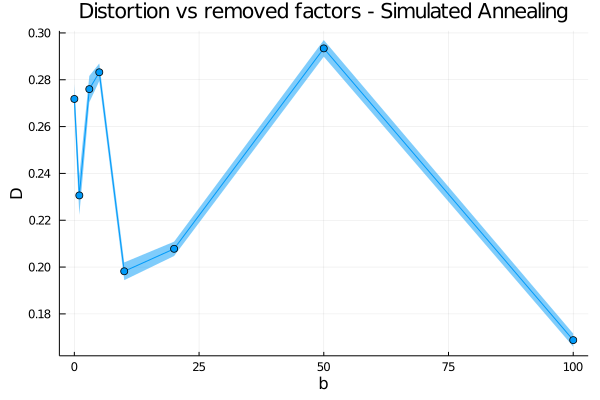

In [237]:
dist = distortion.(sims)
avg_dist = mean.(dist)
sd_dist = std.(dist) ./ sqrt(niter)
pl = Plots.plot(bvals, avg_dist, xlabel="b", ylabel="D", label="", ribbon=sd_dist, marker=:circle)
title!("Distortion vs removed factors - Simulated Annealing")